In [235]:
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
import numpy as np
import geopandas
import fiona  # for reading in shapefiles
import pylab as p
import seaborn as sns
from shapely.geometry import Point, Polygon 
color = sns.color_palette()
%matplotlib inline

In [236]:
#load data
dataset = pd.read_csv("./checkin_dataset.csv")
#drop unnecessary column
dataset = dataset.drop("Unnamed: 0", axis=1)
#print first 10 rows
print(dataset.head(10))

   user            timestamp  xcoordinate  ycoordinate
0    12  2017-07-13 09:36:00     0.906835     0.776484
1    12  2017-07-30 15:23:00     0.928587     0.804964
2    12  2017-05-05 00:41:00     0.904091     0.784043
3    12  2017-07-26 06:10:00     0.906752     0.804461
4    12  2017-05-22 13:22:00     0.900641     0.781683
5    12  2017-06-11 13:05:00     0.899680     0.790893
6     8  2017-07-13 09:40:00     0.873765     0.808707
7     8  2017-07-30 15:23:00     0.913476     0.789742
8     8  2017-05-05 00:43:00     0.915256     0.790685
9     8  2017-07-26 06:12:00     0.916273     0.785860


In [237]:
#transform x, y coordinates into geopandas coordinate
dataset['Coordinate'] = [Point(lon, lat) for lon, lat in zip(dataset['xcoordinate'], dataset['ycoordinate'])]

In [238]:
#print first 10 rows
print(dataset.head(10))

   user            timestamp  xcoordinate  ycoordinate  \
0    12  2017-07-13 09:36:00     0.906835     0.776484   
1    12  2017-07-30 15:23:00     0.928587     0.804964   
2    12  2017-05-05 00:41:00     0.904091     0.784043   
3    12  2017-07-26 06:10:00     0.906752     0.804461   
4    12  2017-05-22 13:22:00     0.900641     0.781683   
5    12  2017-06-11 13:05:00     0.899680     0.790893   
6     8  2017-07-13 09:40:00     0.873765     0.808707   
7     8  2017-07-30 15:23:00     0.913476     0.789742   
8     8  2017-05-05 00:43:00     0.915256     0.790685   
9     8  2017-07-26 06:12:00     0.916273     0.785860   

                                  Coordinate  
0       POINT (0.906835415245 0.77648365603)  
1  POINT (0.9285871007790001 0.804963534519)  
2      POINT (0.904091136788 0.784043025546)  
3      POINT (0.906752305581 0.804461476079)  
4  POINT (0.900641331999 0.7816826230130001)  
5       POINT (0.899680346191 0.79089253574)  
6      POINT (0.873765362159 0.8

In [239]:
#group by user
group_by_user = dataset.groupby("user", as_index=False).size()

In [240]:
#find the user with most data
print(group_by_user[group_by_user == max(group_by_user)])

user
1    1426
dtype: int64


In [241]:
#prepare coordinates for mapping
geo_data = geopandas.GeoDataFrame(dataset, geometry='Coordinate')
geo_data.crs = {'init': 'epsg:4326'}

In [242]:
#prepare background world map for visualization
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.crs = {'init': 'epsg:4326'}

In [243]:
#plot coordinates onto a world map
def plot_map(dataset, bgd_map, xlim, ylim):
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.set_aspect('equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    water = 'lightskyblue'
    earth = 'cornsilk'
    ax.set_facecolor(water)
    bgd_map.plot(ax=ax, facecolor=earth)
    dataset.plot(ax=ax, marker='o', color='red', markersize=5)
    plt.show()

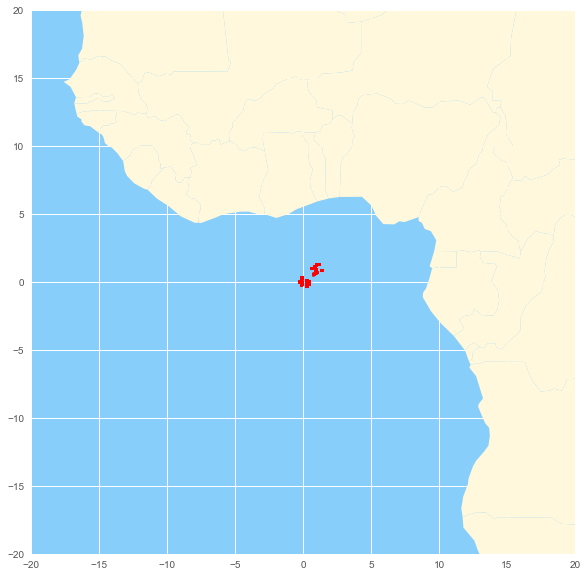

In [244]:
plot_map(geo_data, world, [-20, 20], [-20, 20])

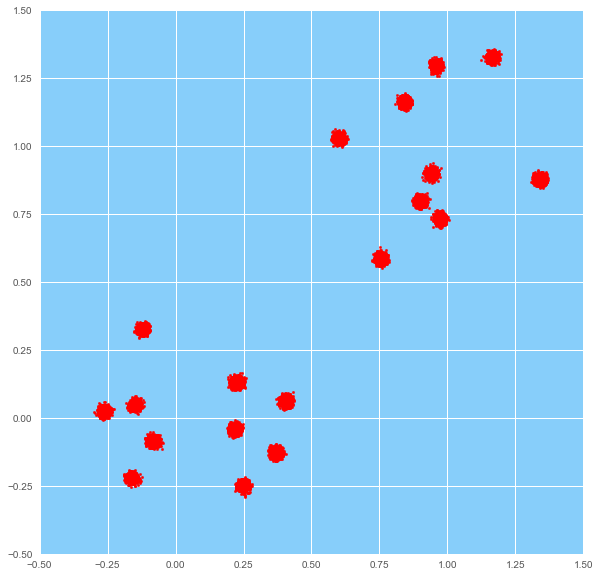

In [245]:
#zoom in
plot_map(geo_data, world, [-0.5, 1.5], [-0.5, 1.5])

It is clear from above that the users' locations are constrained into 18 geographical areas.

/Users/seungwooson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


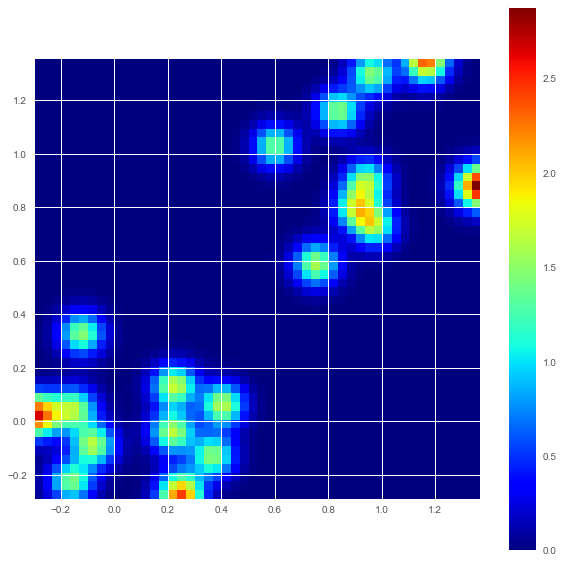

In [246]:
#produce heatmap to get better sense of density of data points within each regions
def get_heatmap(dataset, bins=(100,100), smoothing=1.3, cmap='jet'):
    def retrieve_x(pt):
        return pt.coords[0][0]

    def retrieve_y(pt):
        return pt.coords[0][1]

    x = list(dataset.geometry.apply(retrieve_x))
    y = list(dataset.geometry.apply(retrieve_y))
    heatmap, x_side, y_side = np.histogram2d(y, x, bins=bins)
    extent = [y_side[0], y_side[-1], x_side[-1], x_side[0]]

    log_heatmap = np.log(heatmap)
    log_heatmap[np.isneginf(log_heatmap)] = 0
    log_heatmap = ndimage.filters.gaussian_filter(log_heatmap, smoothing, mode='nearest')
    plt.figure(figsize=(10,10))
    plt.imshow(log_heatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

get_heatmap(geo_data, bins=50, smoothing=1.5)

From this, it is clear that regions with red color are the most populous regions - areas where most users are located in.

Now that we have garnered a general sense of location and density of geospatial user data, we can build an LSTM (Long-Short Term Memory) neural network model to make predictions as to which region (out of the 18 clusters) a user is likely to be in in the future. 

Let us use user 1 since we have already discovered from above that there are most data points related to user 1. 

In [247]:
#filter dataset into user1 data and sort in ascending order of time
data_1 = dataset[dataset["user"] == 1]
data_1= data_1.set_index(pd.DatetimeIndex(data_1["timestamp"])) 
data_1 = data_1.sort_index()
data_1.head(10)

,user,timestamp,xcoordinate,ycoordinate,Coordinate
timestamp,,,,,
2017-05-01 01:58:00,1,2017-05-01 01:58:00,-0.127167,0.330471,POINT (-0.127167386704 0.330471266206)
2017-05-01 02:33:00,1,2017-05-01 02:33:00,0.910195,0.790597,POINT (0.910194606524 0.7905972677150001)
2017-05-01 05:30:00,1,2017-05-01 05:30:00,0.970965,0.739569,POINT (0.970964547055 0.7395694062360001)
2017-05-01 06:21:00,1,2017-05-01 06:21:00,-0.116370,0.326636,POINT (-0.116369626321 0.326636132551)
2017-05-01 07:08:00,1,2017-05-01 07:08:00,0.898376,0.808967,POINT (0.8983757130779999 0.8089670496410001)
2017-05-01 07:11:00,1,2017-05-01 07:11:00,0.240780,-0.030213,POINT (0.24078015674 -0.0302133015575)
2017-05-01 09:42:00,1,2017-05-01 09:42:00,-0.270170,0.028009,POINT (-0.270169788221 0.0280087534145)
2017-05-01 12:00:00,1,2017-05-01 12:00:00,0.597660,1.024739,POINT (0.597659592704 1.02473902095)
2017-05-01 13:02:00,1,2017-05-01 13:02:00,0.851361,1.149795,POINT (0.851361472547 1.14979492833)


In [248]:
#transform user 1 data into 2D numpy array
data_1_np = data_1[["xcoordinate", "ycoordinate"]].values
data_1_np

array([[-0.12716739,  0.33047127],
       [ 0.91019461,  0.79059727],
       [ 0.97096455,  0.73956941],
       ..., 
       [ 0.61077757,  1.00269095],
       [ 0.8988516 ,  0.80467056],
       [-0.10529558,  0.32130569]])

In [249]:
#We will use KMeans flat clustering method to assign geospatial clusters each a label. 

In [250]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=19)
kmeans.fit(data_1_np)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
labels= labels+1
print(centroids)
print(labels)

[[ 0.90166537  0.79734761]
 [ 0.2184789  -0.0406206 ]
 [-0.2612883   0.02275391]
 [ 1.34304804  0.87717981]
 [ 0.9569462   1.29765284]
 [-0.1225787   0.32713242]
 [ 0.84061993  1.16320011]
 [ 0.36970325 -0.12774327]
 [ 0.75534305  0.58461454]
 [ 0.22430325  0.13178817]
 [-0.08273432 -0.0856818 ]
 [ 0.60305677  1.02782687]
 [ 0.40507742  0.06235197]
 [ 0.24921249 -0.24736044]
 [-0.15973545 -0.2215193 ]
 [ 0.97279081  0.73296684]
 [-0.14803686  0.04881254]
 [ 0.94193907  0.89823434]
 [ 1.17394568  1.32845054]]
[ 6  1 16 ..., 12  1  6]


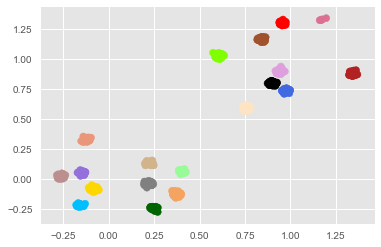

In [251]:
#Each coordinates are assigned a color label from 19 possible regions.
colors = ["black", "gray", "rosybrown", "firebrick", "red", "darksalmon", "sienna", "sandybrown", "bisque", "tan", "gold", "chartreuse", "palegreen", "darkgreen", "deepskyblue", "royalblue", "mediumpurple", "plum", "palevioletred"]
x = data_1["xcoordinate"].values
y = data_1["ycoordinate"].values
t = [colors[labels[i]-1] for i in range(len(labels))]

plt.scatter(x, y, c=t)
plt.show()

Now, we have successfully used unsupervised machine learning techniques to assign labels to the cluster regions.

We will use Facebook's forecasting tool, Prophet, to predict which cluster user 1 is likely to be in at a given time. This is due to the fact that Prophet works well with univariate regression models, and our data is univariate (cluster labels)

In [254]:
#prepare data for forecasting which region user1 is likely to be in
data_1_v2 = pd.DataFrame(labels).set_index(data_1.index)
data_1_v2.columns = ["Label"]
test_prophet = pd.DataFrame()
test_prophet["ds"] = data_1_v2.index
test_prophet["y"] = data_1_v2["Label"].reset_index(drop=True)
test_prophet["y"] = np.log(test_prophet["y"])
test_prophet.head()

,ds,y
0,2017-05-01 01:58:00,1.791759
1,2017-05-01 02:33:00,0.000000
2,2017-05-01 05:30:00,2.772589
3,2017-05-01 06:21:00,1.791759
4,2017-05-01 07:08:00,0.000000


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


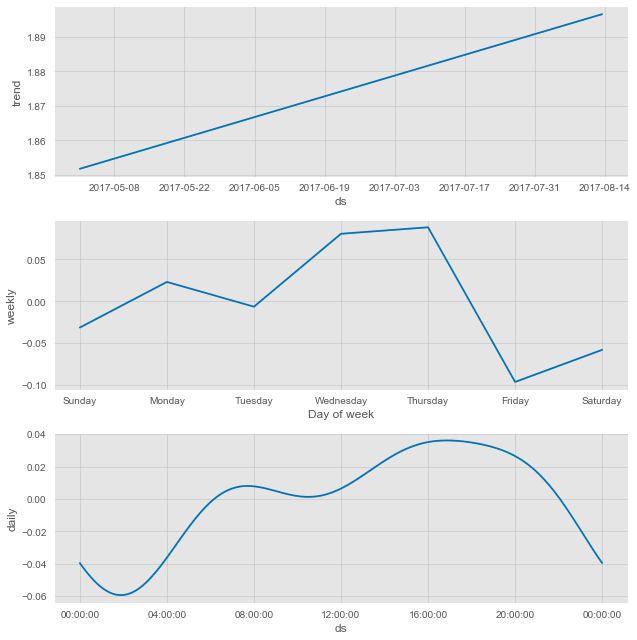

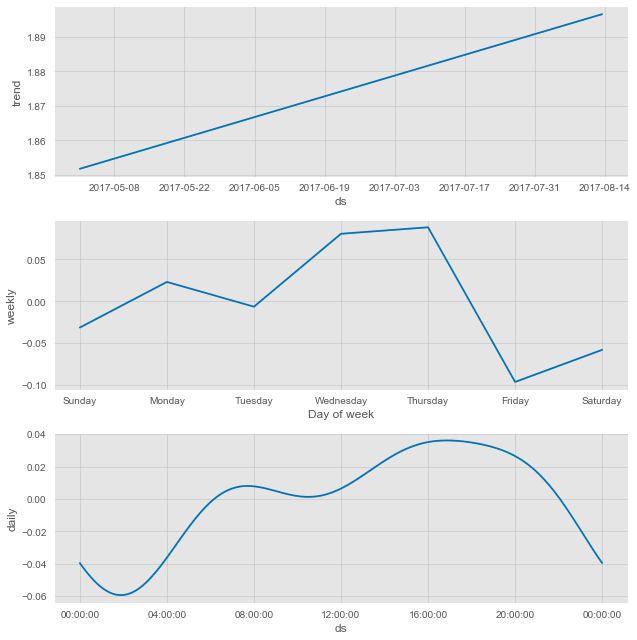

In [255]:
from fbprophet import Prophet
import math
m = Prophet(changepoint_prior_scale=0.01).fit(test_prophet)
future = m.make_future_dataframe(periods=300, freq="H")
forecast = m.predict(future)
m.plot_components(forecast)

From first graph we can clearly see that user1 is moving from one region to the other gradually as time passes from May to August. 

From second graph we can clearly see that in certain days of the week user 1 is likely to be at a certain region. (The y-axis are in log values of the label region values (from 1-19). 